### Import models and load data

In [1]:
from torchvision import datasets
import torch
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

# Import all models
from BaseNet import *
from ConvNet1 import *
#from NetSharing import *

mini_batch_size = 1000
nb_epochs = 300
nb_runs = 2
eta = 0.001

train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)

/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### 1channel2images

In [ ]:
from importlib import reload
import _1channel2images
reload(_1channel2images)
from _1channel2images import *

print("Working with 1channel2images framework, nb_classes = ", nb_classes)

#model = BaseNet1C(nb_classes)
model_1C = ConvNet1_1C(nb_classes)
optimizer_1C = torch.optim.SGD(model_1C.parameters(), lr=eta, momentum=0.95)
test_results_1C = multiple_training_runs(model_1C, 2, optimizer_1C, train_input, train_classes,
                                      test_input, test_target, test_classes, mini_batch_size, nb_epochs)
write_to_csv('1channel2images.csv', model_1C, test_results_1C)

Working with 1channel2images framework, nb_classes =  10
phase: train, epoch: 100, loss: 1.45889, acc: 0.7880
phase: val, epoch: 100, loss: 1.44106, acc: 0.7930
phase: train, epoch: 200, loss: 0.27122, acc: 0.9640
phase: val, epoch: 200, loss: 0.26859, acc: 0.9645
phase: train, epoch: 300, loss: 0.10641, acc: 0.9915
phase: val, epoch: 300, loss: 0.10568, acc: 0.9915
Training complete in 2 min 54 s
Best val acc: 0.9915
phase: train, epoch: 100, loss: 1.37745, acc: 0.7975
phase: val, epoch: 100, loss: 1.36124, acc: 0.8040


In [ ]:
# This is just for visualization of our results but it will have to be taken away for the report 
# since we can't use any additional libraries
import pandas as pd

print(test_results_1C)
write_to_csv('1channel2images.csv', model_1C, test_results_1C)
data = pd.read_csv('1channel2images.csv')
data.head()

### 2channels1image

In [ ]:
import _2channels1image
reload(_2channels1image)
from _2channels1image import *

print("Working with 2channels1image framework, nb_classes = ", nb_classes)

model_2C = ConvNet1_2C(nb_classes)
optimizer_2C = torch.optim.SGD(model_2C.parameters(), lr=0.00001, momentum=0.95)  
test_results_2C = multiple_training_runs(model_2C, 2, optimizer_2C, train_input, train_target,
                           test_input, test_target, mini_batch_size, nb_epochs)
write_to_csv('2channels1image.csv', model_2C, test_results_2C)

In [ ]:
print(test_results_2C)
write_to_csv('2channels1image.csv', model_2C, test_results_2C)
data = pd.read_csv('2channels1image.csv')
data.head()

### Weight Sharing

In [ ]:
import weight_sharing
reload(weight_sharing)
from weight_sharing import *

print("Working with weight_sharing framework")

model_ws = NetSharing1()
optimizer_ws = torch.optim.SGD(model_ws.parameters(), lr=0.00001, momentum=0.95)  
test_results_ws = multiple_training_runs(model_ws, nb_runs, optimizer_ws, train_input, train_target,
                           test_input, test_target, mini_batch_size, nb_epochs)
write_to_csv('weightsharing.csv', model_ws, test_results_ws)

In [ ]:
print(test_results_ws)
write_to_csv('weightsharing.csv', model_ws, test_results_ws)
data = pd.read_csv('weightsharing.csv')
data.head()

### Auxiliary Losses

In [ ]:
import auxiliary_losses
reload(auxiliary_losses)
from auxiliary_losses import *
import Incept1
reload(Incept1)
from Incept1 import *
nb_epochs = 300
print("Working with auxiliary losses framework")

model_aux = Incept1()
optimizer_aux = torch.optim.SGD(model_aux.parameters(), lr=0.00001, momentum=0.95)  
test_results_aux = multiple_training_runs(model_aux, nb_runs, optimizer_aux, train_input, train_target, train_classes, 
                                          test_input, test_target, test_classes, mini_batch_size, nb_epochs)
write_to_csv('auxiliary_losses.csv', model_aux, test_results_aux)

In [ ]:
print(test_results_aux)
write_to_csv('auxiliary_losses.csv', model_aux, test_results_aux)
data = pd.read_csv('auxiliary_losses.csv')
data.head()

## Weight Sharing and Auxiliary Loss Models (Youssef).

In [2]:
print(train_input.shape, train_target.shape, train_classes.shape, test_input.shape, test_target.shape, test_classes.shape)

torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2]) torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2])


In [3]:
from torch.autograd import Variable
from WSharingModel import *
from torch import nn, optim
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
import torch
from torchvision import datasets
from torch import optim
import dlc_practical_prologue as prologue
from AuxModel import *
from SimpleCNN import *
from torch.autograd import Variable
from torch.nn import functional as F


#### Function that draws the evolution of the loss during training.

In [4]:
def visualize_loss(model,loss_model,lr):
    plt.plot(loss_model[0],loss_model[1], color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evolution of the loss during training with learning rate {:>3} of the model {:>5}.'.format(lr,model.__class__.__name__))
    plt.show()

#### Function that prints the results of the prediction one the model is trained.

In [5]:
def print_results(model,optimizer,learning_rate,NB_EPOCHS,MINI_BATCH_SIZE, train_input, train_target,test_input, test_target):
     print('model: {:6}, optimizer: {:6}, learning rate: {:6}, num epochs: {:3}, '
                    'mini batch size: {:3}, train error: {:5.2f}%, test error: {:5.2f}%'.format(model.__class__.__name__,optimizer.__name__,learning_rate,NB_EPOCHS,MINI_BATCH_SIZE,model.compute_nb_errors(model, train_input, train_target, MINI_BATCH_SIZE) / train_input.size(0) * 100,model.compute_nb_errors(model, test_input, test_target, MINI_BATCH_SIZE) / test_input.size(0) * 100
                    )
                )

### Treatement of our Training and Testing Data.

In [6]:
# normalize it
mean, std = train_input.mean(), train_input.std() 
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes)
test_input, test_target = Variable(test_input), Variable(test_target)

### We define our Learning parameters.

In [7]:
NB_EPOCHS = 50
MINI_BATCH_SIZE = 100
learning_rates = [0.1]

### We define our optimizers and losses and weights for the auxiliary losses.

In [8]:
op = torch.optim.SGD
losses = [CrossEntropyLoss(),BCEWithLogitsLoss()]
alpha = 0.8
beta = 0.2

### Training of Different Models and Results on Training and Testing set.

Loss at epoch  0 : 1.6457089185714722  
Loss at epoch 49 : 0.006563572678714991  
model: WSModel, optimizer: SGD   , learning rate:    0.1, num epochs:  50, mini batch size: 100, train error:  0.00%, test error: 15.00%


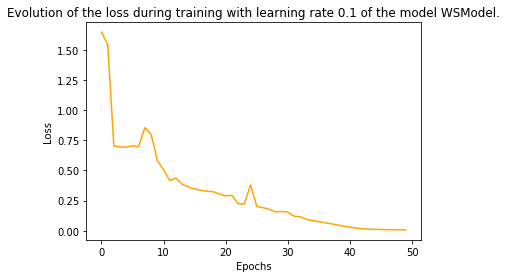

Loss at epoch  0 : 0.6531750559806824  
Loss at epoch 49 : 0.00250547775067389  
model: WSModel1, optimizer: SGD   , learning rate:    0.1, num epochs:  50, mini batch size: 100, train error:  0.00%, test error: 14.10%


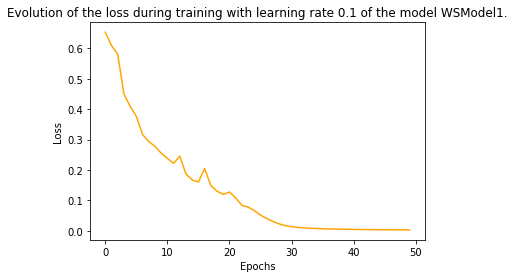

Loss at epoch  0 : 1.4711363315582275  
Loss at epoch 49 : 0.4347169101238251  
model: AuxModel, optimizer: SGD   , learning rate:    0.1, num epochs:  50, mini batch size: 100, train error:  0.90%, test error: 12.40%


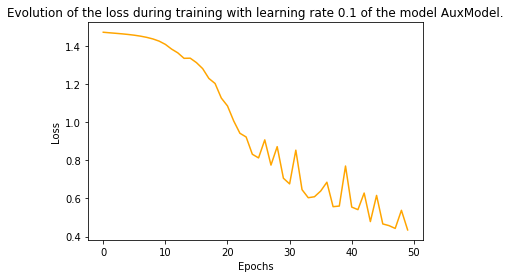

Loss at epoch  0 : 1.4537765979766846  
Loss at epoch 49 : 0.021871600300073624  
model: AuxModel1, optimizer: SGD   , learning rate:    0.1, num epochs:  50, mini batch size: 100, train error:  0.00%, test error:  9.90%


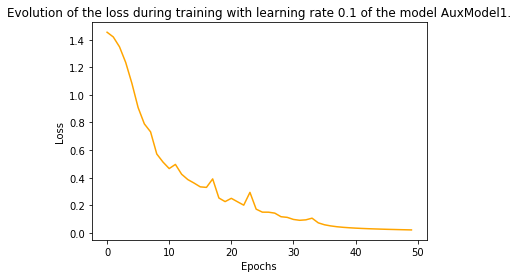

torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
Loss at epoch  0 : 0.6699336171150208  
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([10

torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6

torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6

torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2

torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 1

torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6])
torch.Size([100, 128, 2, 2])
torch.Size([100, 2, 14, 14])
torch.Size([100, 64, 6, 6

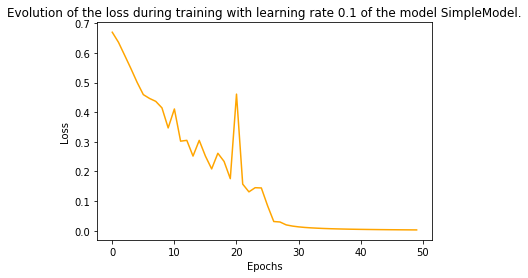

In [9]:
 for j in range(0,5):
        for i in range(len(learning_rates)):
            models = [WSModel(),WSModel1(),AuxModel(),AuxModel1(),SimpleModel()]
            model = models[j]
            optimizer = op(model.parameters(),lr = learning_rates[i])
            if (j<2):
                #print("here")
                loss_aux = train_model_WS(model, optimizer,  train_input, train_target, NB_EPOCHS, MINI_BATCH_SIZE,losses[0])
            elif(j>1 and j!=4):
                #print("here here")
                loss_aux = train_model_AM(model, optimizer,  train_input, train_target, train_classes,NB_EPOCHS, MINI_BATCH_SIZE,losses[0],alpha,beta)
            elif(j==4):
                loss_aux = train_model(model, optimizer,  train_input, train_target, NB_EPOCHS, MINI_BATCH_SIZE,losses[0])
            #print("model:",model)
            print_results(model,op,learning_rates[i],NB_EPOCHS,MINI_BATCH_SIZE, train_input, train_target,test_input, test_target)
            visualize_loss(model,loss_aux,learning_rates[i])